In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/B_GEN/bgflow")
import bgflow
sys.path.insert(0, "/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/B_GEN/anode")
import anode

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from bgflow.utils import (assert_numpy, distance_vectors, distances_from_vectors, 
                          remove_mean, IndexBatchIterator, LossReporter, as_numpy, compute_distances
)
from bgflow import (GaussianMCMCSampler, DiffEqFlow, BoltzmannGenerator, Energy, Sampler, 
                    MultiDoubleWellPotential, MeanFreeNormalDistribution, KernelDynamics)

from glob import glob

In [4]:
#fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T1.0_P0.*.lammpstrj')
#fnames = fnames + glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T0.700_P0.0000020000.lammpstrj')
#fnames = glob('/home/ninarell/OneDrive/WF_GAN_FOR_GLASSES/LJ_CRYSTAL/T_0.700_box/dumplin/dump.npt_nose_T1.0_P0.0000000000.lammpstrj')
#arrays = [np.loadtxt(f, skiprows=9)[:,2:5] for f in fnames]
#coordinates = np.array(arrays)
temperature = float(1.00)
side=1.7544 #3.
n_particles = 2 #len(coordinates[0])
spacial_dim = 2
dim_ics = n_particles * spacial_dim
#coordinates=coordinates.reshape(len(arrays), dim_ics)

In [5]:
from  bgflow.distribution.energy import LennardJonesPotentialPPP
from  bgflow.distribution.energy import LennardJonesPotential
rm = 2**(1./6.)
#target = LennardJonesPotentialPPP(dim = dim_ics, n_particles = n_particles, side = side, oscillator = False, rm=rm, two_event_dims=False)
target = LennardJonesPotential(dim = dim_ics, n_particles = n_particles,oscillator = False,  two_event_dims=False)

In [6]:
def plot_energy(coordinates, target):
    xs = torch.Tensor(coordinates)
    #xs = xs.view(-1,10,3)
    energy = target.energy(xs).detach().numpy()
    x=np.arange(1,len(energy)+1)

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)

In [7]:
def plot_energy(coordinates, target):
    xs = torch.Tensor(coordinates)
    #xs = xs.view(-1,10,3)
    energy = target.energy(xs).detach().numpy()
    x=np.arange(1,len(energy)+1)

    fig = plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, energy)

    plt.subplot(1, 2, 2)
    counts, bins = np.histogram(energy, density=True)
    plt.yscale("log")
    plt.stairs(counts, bins)

In [8]:
#Box constraint
def constraint(x):
    return torch.where((abs(x) > side).clone().detach(), x - 2 * side * torch.sign(x) * torch.floor(abs(x)/side), x)

In [9]:
# import random
# import numpy as np

# def generate_random_points(num_points, x_range, y_range, z_range):
#     points = np.empty((num_points, 3))
#     for i in range(num_points):
#         x = random.uniform(x_range[0], x_range[1])
#         y = random.uniform(y_range[0], y_range[1])
#         z = random.uniform(z_range[0], z_range[1])
#         points[i] = [x, y, z]
#     return points

# # Parameters
# num_points = n_particles  # Number of points to generate
# x_range = (-side, side)  # Range for x coordinates
# y_range = (-side, side)  # Range for y coordinates
# z_range = (-side, side)  # Range for z coordinates

# # Generate points
# random_points = generate_random_points(num_points, x_range, y_range, z_range)

# # Print the generated points
# random_points=random_points.reshape(dim_ics)

In [10]:
import random
import numpy as np

def generate_random_points(num_points, x_range, y_range):
    points = np.empty((num_points, 2))
    for i in range(num_points):
        x = random.uniform(x_range[0], x_range[1])
        y = random.uniform(y_range[0], y_range[1])
        points[i] = [x, y]
    return points

# Parameters
num_points = n_particles  # Number of points to generate
x_range = (-side, side)  # Range for x coordinates
y_range = (-side, side)  # Range for y coordinates

# Generate points
random_points = generate_random_points(num_points, x_range, y_range)

# Print the generated points
random_points=random_points.reshape(dim_ics)

In [44]:
# define a MCMC sampler to sample from the target energy

init_state = torch.Tensor(random_points) #zeros(10,3)

#mcsampler = GaussianMCMCSampler(target, init_state=init_state, temperature=temperature, box_constraint=constraint, noise_std=0.15)
mcsampler = GaussianMCMCSampler(target, init_state=init_state, temperature=temperature, noise_std=0.15)
mcsampler.sample(1000)
data = mcsampler.sample(40096)
data = data.view(-1,dim_ics)

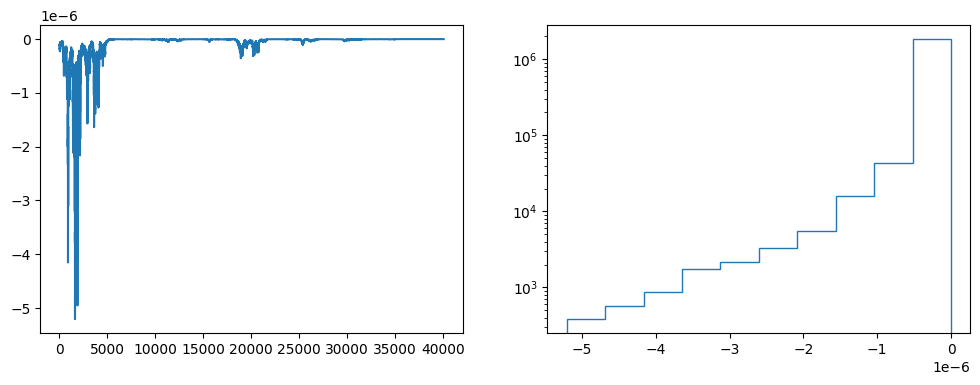

In [45]:
plot_energy(data, target)

In [13]:
# now set up a prior

from bgflow import NormalDistribution, TruncatedNormalDistribution, MeanFreeNormalDistribution

mean = torch.Tensor(data[40]).view(dim_ics)
cov = torch.zeros(dim_ics, dim_ics)
cov = cov.fill_diagonal_(0.01)

prior = NormalDistribution(dim_ics, mean=mean, cov=cov)
#prior =  MeanFreeNormalDistribution(dim_ics, n_particles, two_event_dims=False)

# upper_bound=torch.ones(dim_ics)*side
# lower_bound=-upper_bound
# sigma=torch.ones(dim_ics)*0.002
# prior = TruncatedNormalDistribution(mu=mean, sigma=sigma, lower_bound=lower_bound, upper_bound=upper_bound,  is_learnable=True)

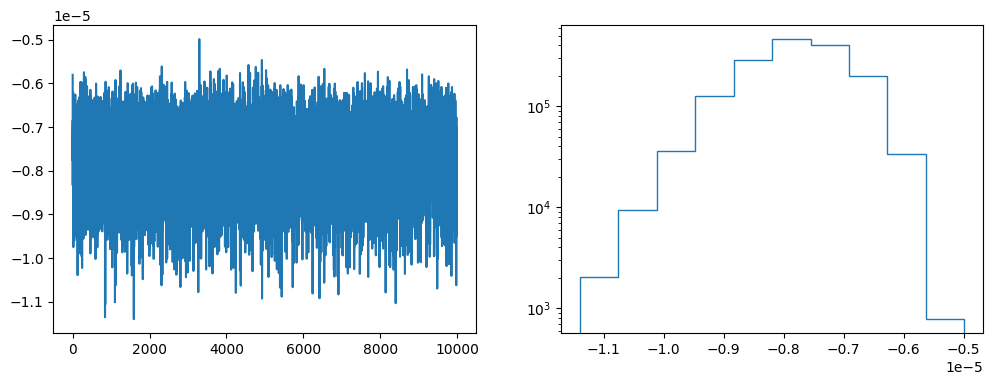

In [14]:
#data_prior = prior._sample_with_temperature(10000, temperature=temperature)
data_prior = prior.sample(10000)
#data_prior = data_prior.view(-1, 10, 3)
plot_energy(data_prior, target)

In [15]:
data_prior

tensor([[-0.2834, -1.2379,  4.1747,  5.8489],
        [-0.3095, -0.9697,  3.7512,  5.7866],
        [-0.2737, -1.1985,  3.7749,  5.6296],
        ...,
        [-0.2346, -0.8443,  3.8437,  5.9539],
        [-0.1102, -1.0452,  3.8579,  5.8135],
        [-0.1808, -1.0085,  3.7262,  5.7411]])

In [31]:
# set of the equivariant kernel dynamics

n_dimensions = spacial_dim
d_max = 8
mus = torch.linspace(0, d_max, 50) #.cuda()

mus.sort()
gammas = 0.3 * torch.ones(len(mus)) #.cuda()

mus_time = torch.linspace(0, 1, 10) #.cuda()
gammas_time = 0.3 * torch.ones(len(mus_time)) #.cuda()


kdyn = KernelDynamics(n_particles, n_dimensions, mus, gammas, optimize_d_gammas=True, optimize_t_gammas=True,
                      mus_time=mus_time, gammas_time=gammas_time, periodic = True, side = side) #.cuda()


In [32]:
flow = DiffEqFlow(
    dynamics = kdyn
)

In [33]:
# having a flow and a prior, we can now define a Boltzmann Generator

bg = BoltzmannGenerator(prior, flow, target) #.cuda()

In [34]:
# initial training with likelihood maximization on data set

n_kl_samples = 64
n_batch = 64
batch_iter = IndexBatchIterator(len(data), n_batch)

optim = torch.optim.Adam(bg.parameters(), lr=1e-4)

n_epochs = 10
n_report_steps = 4

# mixing parameter
lambdas = torch.linspace(1., 0.1, n_epochs) #.cuda()

reporter = LossReporter("NLL", "KLL")

In [35]:
# use DTO in the training process
flow._use_checkpoints = True

# Anode options
options={
    "Nt": 3,
    "method": "RK4"
}
flow._kwargs = options

In [36]:
for epoch, lamb in enumerate(lambdas):
    for it, idxs in enumerate(batch_iter):
        batch = data[idxs] #.cuda()
        
        optim.zero_grad()

        # negative log-likelihood of the batch is equal to the energy of the BG
        nll = bg.energy(batch).mean()
        # aggregate weighted gradient
        (0.5 * nll).backward()
        
        # kl divergence to the target
        kll = bg.kldiv(n_kl_samples).mean()

        # aggregate weighted gradient
        ((1. - 0.5) * kll).backward()
        
        reporter.report(nll, kll)
        
        optim.step()
        
        if it % n_report_steps == 0:
            print("\repoch: {0}, iter: {1}/{2}, lambda: {3}, NLL: {4:.4}, KLL: {5:.4}".format(
                    epoch,
                    it,
                    len(batch_iter),
                    lamb,
                    *reporter.recent(1).ravel()
                ), end="")

epoch: 9, iter: 60/64, lambda: 0.10000000149011612, NLL: 2.758e+03, KLL: -0.2363

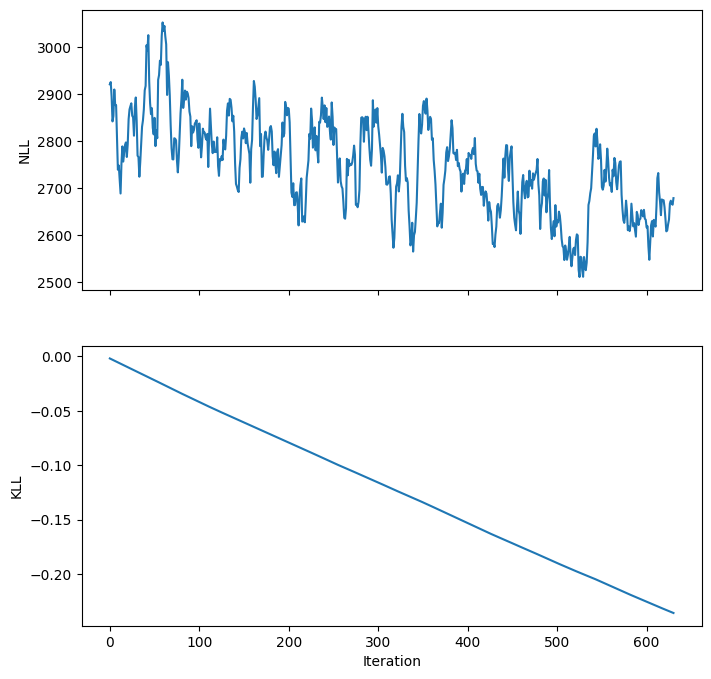

In [37]:
reporter.plot()

In [38]:
n_samples = 200000
samples, latent, dlogp = bg.sample(n_samples, with_latent=True, with_dlogp=True)
log_w = as_numpy(bg.log_weights_given_latent(samples, latent, dlogp))

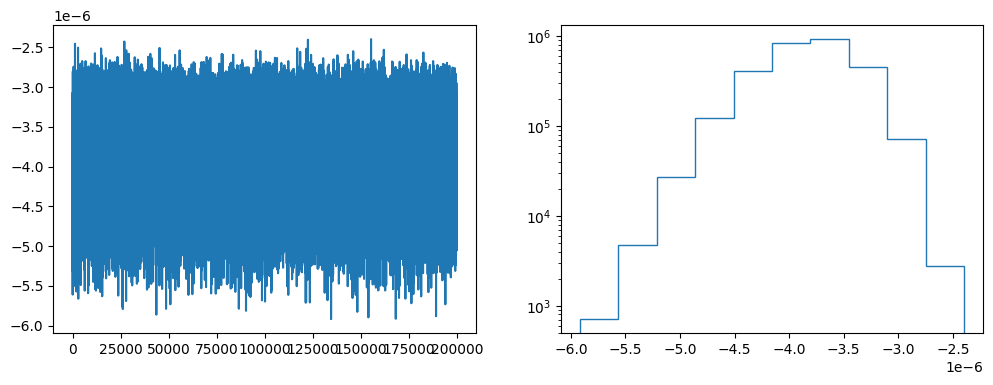

In [39]:
plot_energy(samples, target)

In [40]:
samples

tensor([[-0.3650, -1.5221,  4.1341,  6.2737],
        [-0.3162, -1.4556,  4.0825,  6.1067],
        [-0.5782, -1.4164,  4.2363,  6.3449],
        ...,
        [-0.4515, -1.3690,  4.1851,  6.2822],
        [-0.4800, -1.4599,  4.0408,  6.2258],
        [-0.3732, -1.3704,  4.1092,  6.1230]], grad_fn=<SliceBackward0>)

In [41]:
data[40]

tensor([-2.0713, -3.4101,  2.0713,  3.4101])

In [42]:
samples = remove_mean(samples, n_particles, spacial_dim)
distances_x = as_numpy(compute_distances(samples,  n_particles, spacial_dim))

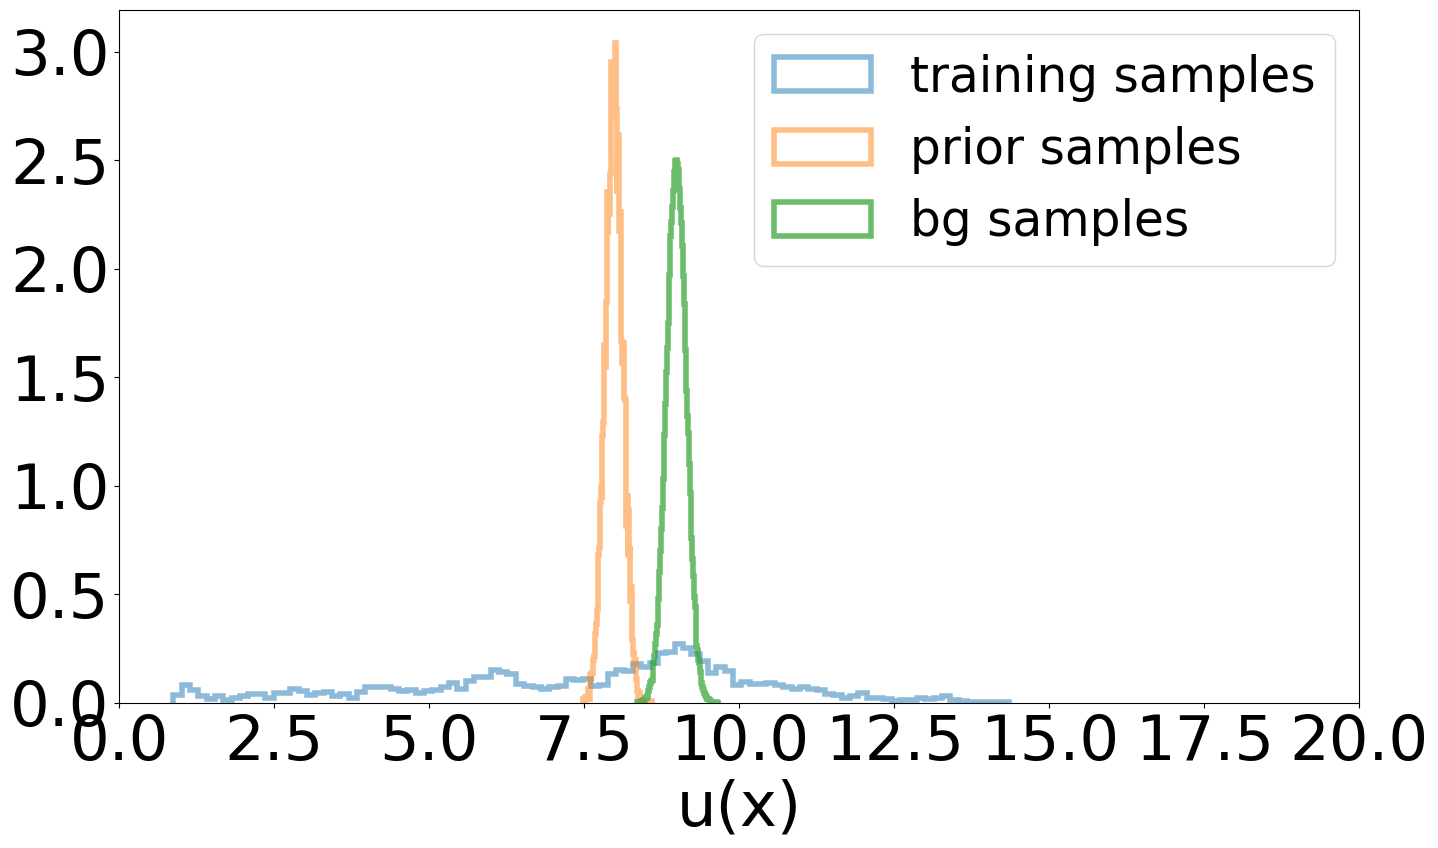

In [43]:
plt.figure(figsize=(16,9))
#plt.plot(d, e, label="Groundtruth", linewidth=4, alpha = 0.5)
data = remove_mean(data, n_particles, spacial_dim)
dists_data = as_numpy(compute_distances(data, n_particles, spacial_dim))
data_prior = remove_mean(data_prior, n_particles, spacial_dim)
dists_data_prior = as_numpy(compute_distances(data_prior, n_particles, spacial_dim))


plt.hist(dists_data.reshape(-1), bins=100, label="training samples", alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(dists_data_prior.reshape(-1), bins=100, label="prior samples", alpha=0.5, density=True, histtype='step', linewidth=4);
plt.hist(distances_x.reshape(-1), bins=100, label="bg samples", alpha=0.7, density=True, histtype='step', linewidth=4);
#plt.hist(distances_x.reshape(-1), bins=100, label="reweighted bg samples", alpha=0.7, density=True, histtype='step', linewidth=4, weights=np.exp(log_w));
plt.xlim(0,20)
plt.legend(fontsize=35)
plt.xlabel("u(x)", fontsize=45)  
plt.xticks(fontsize=45) 
plt.yticks(fontsize=45);